# Segmentare pe bază de varianță

Segmentarea pe baza de varianță pornește de la următoarele observații:
 - zona activă a unei imagini cu o amprentă are o variantă ridicată
 - zonele de fundal au o varianță scăzută
 - zonele marginale ale unei amprente (care pot fi tăiate) nu sunt importante.

 Algoritmul implică împărțirea imaginii în blocuri mici și calculul varianței fiecărui bloc.

 Blocurile cu varianță mai mică decât o anumită valoare se elimină.


In [12]:
import cv2
from google.colab import files
import numpy as np
from google.colab.patches import cv2_imshow
import ipywidgets as widgets

## Extrage blocurile de varianta ridicata

Extragerea blocurilor de varianta ridicată împarte imaginea în blocuri de dimensiunea n și calculeaza varianta fiecarui bloc. Ulterior, returnează lista blocurilor care au varianța mai mare decât parametrul variance_threshold

Varianta se calculează cu ajutorul funcție var din pachetul numpy.

In [4]:
def extract_high_variance_blocks(image, n, variance_threshold):
    height, width = image.shape

    num_blocks_y = height // n
    num_blocks_x = width // n

    # List to store variances of all blocks
    variances = []

    # Iterate over blocks to calculate variances
    for i in range(num_blocks_y):
        for j in range(num_blocks_x):
            # Extract the block
            y_start = i * n
            y_end = (i + 1) * n
            x_start = j * n
            x_end = (j + 1) * n
            block = image[y_start:y_end, x_start:x_end]

            # Calculate the variance of the block
            block_variance = np.var(block)
            variances.append((block_variance, (y_start, y_end, x_start, x_end, block)))

    # Calculate the mean and max variance of the image
    mean_variance = np.mean([v[0] for v in variances])
    max_variance = max([v[0] for v in variances])
    min_variance = min([v[0] for v in variances])

    print(f"Mean variance: {mean_variance}, Max variance: {max_variance}, Min variance: {min_variance}")

    if max_variance == mean_variance:
        print("All blocks have the same variance. Returning an empty list.")
        return []

    # Extract blocks with variance differing by the threshold and calculate gray values
    high_variance_blocks = []
    for block_variance, (y_start, y_end, x_start, x_end, block) in variances:
        variance_diff = block_variance - min_variance
        if variance_diff > variance_threshold:
            # Calculate the gray value for the block
            gray_value = int(((block_variance - (min_variance/variance_threshold)) / (max_variance - (min_variance/variance_threshold))) * 255)
            gray_value = max(0, min(255, gray_value))
            high_variance_blocks.append((y_start, y_end, x_start, x_end, block, gray_value))

    return high_variance_blocks

## Construiește imaginea compusă doar din blocurile primite în variabila blocks

In [21]:
def build_segmented_image(image, blocks):
    # Get image dimensions
    height, width = image.shape

    # Initialize a new image filled with white
    segmented_image = np.full((height, width), 255, dtype=np.uint8)

    # Overlay the extracted blocks onto the segmented image
    for y_start, y_end, x_start, x_end, block, _ in blocks:
        segmented_image[y_start:y_end, x_start:x_end] = block

    return segmented_image

## Construieste o imagine demonstrativă care evidențiază segmentarea

In [17]:
def build_image_with_red_background(image, blocks, n):
    height, width = image.shape

    # Initialize a new RGB image with a red background
    new_image = np.zeros((height, width, 3), dtype=np.uint8)
    new_image[:, :, 2] = 255  # Set the red channel to 255

    # Overlay the extracted blocks
    for y_start, y_end, x_start, x_end, block, gray_value in blocks:
        # Ensure the block doesn't exceed image boundaries for the last row/column
        y_end = min(y_end, height)
        x_end = min(x_end, width)

        # Create a grayscale block with the calculated gray value
        gray_block = np.full((n, n, 3), gray_value, dtype=np.uint8)

        # Insert the block into the new image, adjusting the slice if it's the last row/column
        new_image[y_start:y_end, x_start:x_end] = gray_block[:y_end - y_start, :x_end - x_start]

    return new_image

## Functie pentru interactivitate

Update_image este o functie care asigură interactivitatea în mediul jupyter permitand modificarea continuă a celor doi parametrii

In [28]:
def update_image(n = 20, variance_threshold = 200):
  high_variance_blocks = extract_high_variance_blocks(img, n, variance_threshold)
  red_image = build_image_with_red_background(img, high_variance_blocks, n)
  segmented_image = build_segmented_image(img, high_variance_blocks)
  segmented_image_color = cv2.cvtColor(segmented_image, cv2.COLOR_GRAY2BGR)
  combined_image = np.hstack((red_image, segmented_image_color))
  width=500
  combined_resized = cv2.resize(combined_image, (width, int(combined_image.shape[0] * width / combined_image.shape[1])))
  cv2_imshow(combined_resized)



## Upload al imaginii

Functia permite încărcarea imaginii în mediul jupyter și citirea acesteia într-o variabilă de tip numpy folosind opencv.

Saving 103_6.tif to 103_6.tif
User uploaded file "103_6.tif" with length 145624 bytes


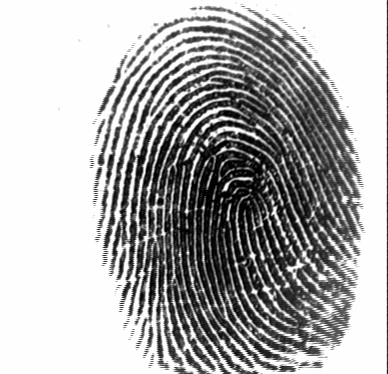

In [30]:
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

  # Read the image using OpenCV
  img = cv2.imdecode(np.frombuffer(uploaded[fn], np.uint8), cv2.IMREAD_UNCHANGED)

  # Now you can work with the image, e.g., display it
  if img is not None:
      cv2_imshow(img) #If you are using colab
  else:
      print("Error: Could not read the image.")



In [31]:
n_slider = widgets.IntSlider(value=20, min=1, max=100, step=1, description='n:')
variance_threshold_slider = widgets.IntSlider(value=200, min=1, max=3000, step=10, description='Variance Threshold:')
widgets.interactive(update_image, n=n_slider, variance_threshold=variance_threshold_slider)

interactive(children=(IntSlider(value=20, description='n:', min=1), IntSlider(value=200, description='Variance…